# CAI4104 Final Project: First CNN Trial

In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
import utils

# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print(f'### NumPy version: {np.__version__}')
print(f'### SciPy version: {sp.__version__}')
print(f'### Scikit-learn version: {sklearn.__version__}')
print(f'### Tensorflow version: {tf.__version__}')
print('------------')



------------
### Python version: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
### NumPy version: 1.26.3
### SciPy version: 1.11.4
### Scikit-learn version: 1.2.2
### Tensorflow version: 2.15.0
------------


## Loading the data

In [2]:
# Relative path to .npy files
data_path = '../data/'
data = np.load(data_path + 'data.npz')

# Load numpy arrays
train_x = data['train_x']
train_t = data['train_t']

val_x = data['val_x']
val_t = data['val_t']

test_x = data['test_x']
test_t = data['test_t']

assert train_x.shape[0] == train_t.shape[0], "Training image quantity mismatches label quantity"
assert val_x.shape[0] == val_t.shape[0], "Validation image quantity mismatches label quantity"
assert test_x.shape[0] == test_t.shape[0], "Test image quantity mismatches label quantity"

# Data shapes
num_images = train_x.shape[0] + val_x.shape[0] + test_x.shape[0]
image_shape = train_x.shape[1:]

print(f'{num_images} images with shape {image_shape}')

35887 images with shape (48, 48, 1)


In [3]:
# Load augmented data
data_aug = np.load(data_path + 'data_aug.npz')
train_x_aug = data_aug['train_x']
train_t_aug = data_aug['train_t']

train_x_aug.shape, train_t_aug.shape

((125600, 48, 48, 1), (125600, 7))

In [4]:
# Append augmented data
train_x_all = np.concatenate((train_x, train_x_aug))
train_t_all = np.concatenate((train_t, train_t_aug))

train_x_all.shape, train_t_all.shape

((150720, 48, 48, 1), (150720, 7))

## Exploring the data

In [5]:
# Category names (implicitly stores labels as indices)
categories = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
category_numbers = dict(zip(categories, np.arange(0, len(categories))))
num_categories = len(categories)

In [11]:
def categorical_to_int(cat):
    return np.argmax(cat)

def display_sample(index: int):
    plt.title(f'Training image {index}: {categories[categorical_to_int(train_t_all[index])]}')
    plt.imshow(train_x_all[index], cmap='gray')

In [18]:
train_t_num = np.array([np.argmax(a) for a in train_t])
train_t_num

array([4, 3, 5, ..., 3, 0, 3], dtype=int64)

(array([3471.,  377., 3559., 6330., 4346., 7037.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

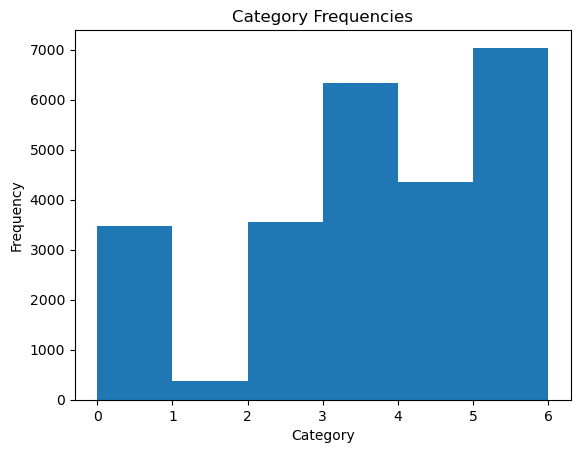

In [19]:
# Plot category frequencies
plt.title('Category Frequencies')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.hist(train_t_num, bins=np.arange(num_categories))


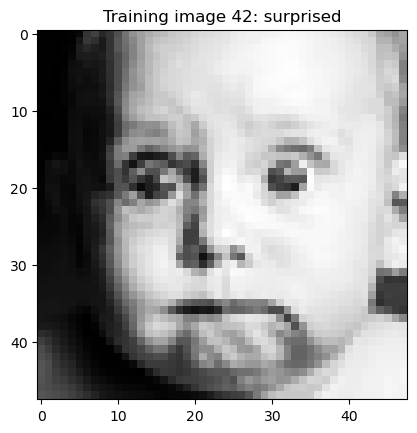

In [22]:
display_index = 42
display_sample(display_index)

## CNN Training

In [24]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


model = keras.models.Sequential(name='CNN')

# Conv-pool repetitions
model.add(Conv2D(48, kernel_size=(5,5), input_shape=image_shape, padding='same', activation='relu', name='conv1'))
model.add(MaxPooling2D(2, name='maxpool1'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(96, kernel_size=(3,3), padding='same', activation='relu', name='conv2'))
model.add(MaxPooling2D(2, name='maxpool2'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(128, kernel_size=(2,2), padding='same', activation='relu', name='conv3'))
model.add(MaxPooling2D(2, name='maxpool3'))
model.add(BatchNormalization())

# Flatten
model.add(Flatten(name='Flatten'))
# Fully connected funnel
model.add(Dense(128, activation='relu', name='fc0'))
model.add(Dropout(0.25, name='drop0'))
model.add(Dense(64, activation='relu', name='fc1'))
model.add(Dropout(0.25, name='drop1'))
model.add(Dense(32, activation='relu', name='fc2'))
model.add(Dropout(0.25, name='drop2'))
# Output
model.add(Dense(num_categories, activation='softmax', name='output'))

# Optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)

model.summary()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 48, 48, 48)        1248      
                                                                 
 maxpool1 (MaxPooling2D)     (None, 24, 24, 48)        0         
                                                                 
 batch_normalization_3 (Bat  (None, 24, 24, 48)        192       
 chNormalization)                                                
                                                                 
 conv2 (Conv2D)              (None, 24, 24, 96)        41568     
                                                                 
 maxpool2 (MaxPooling2D)     (None, 12, 12, 96)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 12, 12, 96)        384       
 chNormalization)                                              

In [25]:
max_epochs = 20
batch_size = 512

early_stop_cb = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=5)

history = model.fit(train_x_all, train_t_all, validation_data=(val_x, val_t), epochs=max_epochs, batch_size=batch_size, 
                    shuffle=True, callbacks=[early_stop_cb], verbose=1)

Epoch 1/20


295/295 [==============================] - 94s 314ms/step - loss: 1.7056 - accuracy: 0.3198 - val_loss: 1.8157 - val_accuracy: 0.2653
Epoch 2/20
295/295 [==============================] - 92s 311ms/step - loss: 1.4749 - accuracy: 0.4313 - val_loss: 1.5382 - val_accuracy: 0.4143
Epoch 3/20
295/295 [==============================] - 92s 311ms/step - loss: 1.3515 - accuracy: 0.4872 - val_loss: 1.3944 - val_accuracy: 0.4780
Epoch 4/20
295/295 [==============================] - 93s 316ms/step - loss: 1.2626 - accuracy: 0.5244 - val_loss: 1.2502 - val_accuracy: 0.5408
Epoch 5/20
295/295 [==============================] - 94s 317ms/step - loss: 1.1814 - accuracy: 0.5588 - val_loss: 1.1689 - val_accuracy: 0.5627
Epoch 6/20
295/295 [==============================] - 92s 310ms/step - loss: 1.1090 - accuracy: 0.5876 - val_loss: 1.1446 - val_accuracy: 0.5794
Epoch 7/20
295/295 [==============================] - 92s 310ms/step - loss: 1.0438 - accuracy: 0.6145 - val_loss: 1.1799 - val_

KeyboardInterrupt: 

In [26]:
model.save('../model/model_cache')

INFO:tensorflow:Assets written to: ../model/model_cache\assets


INFO:tensorflow:Assets written to: ../model/model_cache\assets


In [27]:
loss, acc = model.evaluate(test_x, test_t, verbose=1)
print(f'Test Accuracy: {acc}')

169/169 [==============================] - 1s 6ms/step - loss: 1.3534 - accuracy: 0.5953
Test Accuracy: 0.5952823162078857
